# Task II - Jet Tagging with ParticleNet and LorentzNet

For this task, I chose to start with ParticleNet, which preserves permutation symmetry and is known to work well for jet tagging: https://arxiv.org/abs/1902.08570

* First, we begin by loading the data from the energyflow package, which contains the same data from the zenodo link. Once this is done, we will see the architecture sketched out, and then implement it using PyTorch geometric. I will train the classical GNN on quarks vs gluons, and we'll see what is the corresponding performance, where we consider accuracy, AUC, and the confusion matrix.

* Once this is done, I chose to test the LorentzNet for this task (https://arxiv.org/abs/2201.08187), which is known to be data-efficient and have better generalization than ParticleNet, since it is not only permutation-invariant, but also Lorentz-equivariant. Since the latter is the symmetry of space-time, the performance should be higher, as we'll see. I took the code from the official implementation, which will be used as the **starting point** for **task VI**, where I sketch out and implement a Quantum Lie-Equivariant GNN (Q-LieEGNN), which is a simple modification of LorentzNet. The proposed idea is that, given some experimental data, an appropriate method can be used to find the corresponding Lie algebra basis, like in the LieGAN approach (https://arxiv.org/abs/2302.00236), or in the oracle-preserving latent flows, from Roy T. Forestano et al (https://arxiv.org/abs/2302.00806). From the generators, then, it is possible to find the corresponding metric $J$. The details are left in notebook corresponding to the Task VIII

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install energyflow

2.2.1


In [20]:
# Helper function for visualization.
import matplotlib.pyplot as plt
%matplotlib inline
# Numpy, h5py, etc
import numpy as np
import h5py

torch.cuda.empty_cache()

Set up a GPU for the training and check how much memory is available.

In [3]:
def print_device_usage(device):
  tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
  reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
  allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
  free_memory = reserved_memory-allocated_memory  # free inside reserved
  print('Total memory in Gb: %.2f'%tot_memory)
  print('Reserved memory in Gb: %.2f'%reserved_memory)
  print('Allocated memory in Gb: %.2f'%allocated_memory)
  print('Free memory in Gb: %.2f'%free_memory)


# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)

device :  cuda:0
Total memory in Gb: 11.77
Reserved memory in Gb: 0.00
Allocated memory in Gb: 0.00
Free memory in Gb: 0.00


# Dataset exploration

First, let's download the jet-tagging dataset

Our labels are:
*  0 for gluons
*  1 for quarks

In [4]:
num_classes = 2 #len(np.unique(target))
label_names= ["gluon", "quark"]

In [46]:
features_names

{'px': 0,
 'py': 1,
 'pz': 2,
 'e': 3,
 'erel': 4,
 'pt': 5,
 'ptrel': 6,
 'eta': 7,
 'etarel': 8,
 'etarot': 9,
 'phi': 10,
 'phirel': 11,
 'phirot': 12,
 'deltaR': 13,
 'costheta': 14,
 'costhetarel': 15}

Now let's inspect our data. Each jet is a point cloud/graph with 100 particles/nodes, each of which has 16 features. We have a double-index dataset: (jet index, particle index). The list is cut at 100 constituents per jet. If less constituents are present in the jet/point cloud, the dataset is completed filling it with 0s (zero padding). Note : zero-padding is not using during the training, it is only used to store the ragged dataset.



In [21]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (50000, 100, 16)
Target/Labels shape :  (50000,)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


## About the features

As common in collider physics, a Cartesian coordinate system is used with the $z$ axis oriented along the beam axis, the $x$ axis on the horizontal plane, and the $y$ axis oriented upward. This way, $xy$ define defines the transverse plane, and $z$ defines the longitudinal direction. This can be seen in the following illustration (https://arxiv.org/pdf/2106.11535.pdf):

<img src="figures/particle_cloud_mpgan.png" width=65% style="margin-left:auto; margin-right:auto">

The features available in the zenodo link are the transverse momentum $p_{T}$, the projection of the particle momentum in the $xy$ plane; the pseudorapidity $\eta = -log(tan(\theta / 2))$; and finally, the azimuthal angle $\phi$, computed with respect to the $x$-axis; and the particle id, that identifies each particle. The energyflow dataset provides this same dataset for us, and for this very first experiment I chose to work with just the 3 first features, for simplicity. In the next architecture, we convert these features into 4-momenta to exploit the instrinsic Lorentz symmetry.

## Loading the challenge dataset

In [5]:
import energyflow
X, y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='datasets/QMLHEP/quark_gluons')

In [6]:
features_names = {'pt': 0, 
                  'rapidity': 1, 
                  'azimuthal angle': 2,
                  'pdgid': 3}

In [7]:
features_to_consider = 'pt,rapidity,azimuthal angle'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = X[:,:,features_idx]

In [51]:
print("X has shape: {}\ny has shape: {}".format(X.shape, y.shape))

X has shape: (100000, 139, 4)
y has shape: (100000,)


In [9]:
jetList

array([[[ 0.26876914,  0.35690317,  4.74138734],
        [ 0.16007638, -0.25560953,  4.5502291 ],
        [ 1.14868731, -0.06243802,  4.50385377],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 1.21266321, -0.11285309,  3.04708757],
        [ 0.24089398, -0.01671749,  2.82705667],
        [ 0.10277845, -0.08587205,  3.04180579],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.21682942, -0.99705702,  0.53256891],
        [ 0.2313594 , -1.59192211,  0.20290659],
        [ 0.3415725 , -1.34588077,  0.17991001],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.56230598,  1.30600679,  4.45584187],
        [ 0

In [53]:
features_to_consider = 'pt,rapidity,azimuthal angle,pdgid'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = X[:,:,features_idx]

### Particle distributions
Now let's plot the distributions of the jets consituents (particle/node features).

In [63]:
#Let's define a helper function to plot the distibutions
def plot_features(feat_idx, X_features, y, features_to_consider):
    plt.subplots(figsize=(5,5))
    for jet_type_idx in range(len(label_names)):
        data_feature = X_features[:,:,feat_idx]
        data_feature = data_feature[y == jet_type_idx]
        # then plot the right quantity for the reduced array (merge all constituents together)
        plt.hist(data_feature[:,feat_idx].flatten(), bins=100, density=True, histtype='step', fill=False, linewidth=1.5)
    #plt.yscale('log', nonposy='clip')    
    plt.legend(label_names, fontsize=12, frameon=False)  
    plt.xlabel(features_to_consider[feat_idx], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()


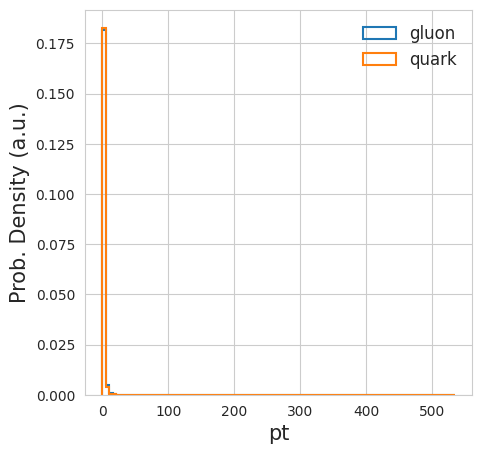

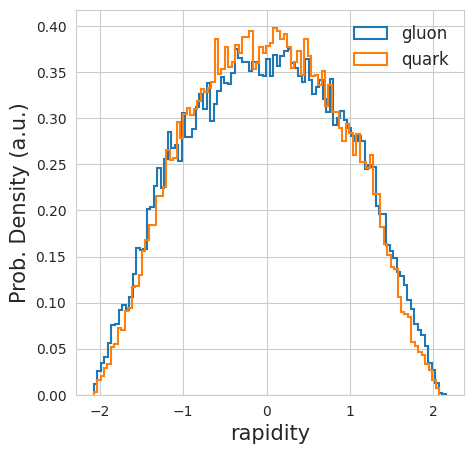

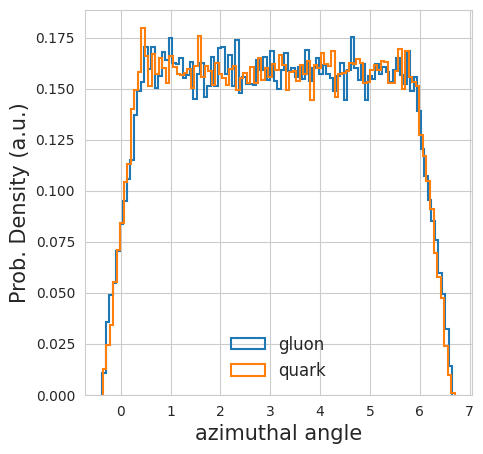

In [64]:
# we now plot all the features
for i in range(len(features_to_consider)):
    plot_features(i, jetList, y, features_to_consider)


# Starting with ParticleNet

ParticleNet relies on [Dynamic Graph Convolutional Neural Networks](https://dl.acm.org/doi/10.1145/3326362) (DGCNN), which are a special case of the GCN where the graph is re-built in the new ${h_i^{(k)}}$ latent space created by the node feature update. The DGCNN uses the EdgeConv operation to create a new latent graph where the original points are projected into a higher dimensional space. For this, for each point, its k-nearest neighbors are found and chosen to be connected to the given point. This can be thought as an analogy to the traditional convolution on images, where $3\times3$ kernels learn correlations for the $8$ nearest neighbors for each pixel on the image, and then they produce a new grid after the convolution operation. This is based on the principle of locality, that says that images are made of local patterns, and so CNNs exploit this property, and analogously, the EdgeConv has the same mechanism. This is the architecture of ParticleNet:

<div>
<img src="https://raw.githubusercontent.com/jngadiub/ML_course_Pavia_23/main/neural-networks/particle-net-arch.png" width="800"/>
</div>

The advantage of such architecture is the natural invariance to permutations. In contrast to other NN flavours, like LSTMs, the ordering here doesn't matter. If we consider the example of text data, before the Transformers and LLMs wave, Recurrent Neural Networks (RNN) were a gold standard for natural language; but the ordering of each token plays a significant context in determining the semantic meaning of sentences. In the case of jets, this is not a good inductive bias, so GNNs are a better option.
Here, I use the built in [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.EdgeConv.html) module with the [`knn_graph`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.knn_graph.html#torch_geometric.nn.pool.knn_graph) method implemented in PyG, with $k=16$ neighbors.

In [10]:
from torch import nn
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_cluster import knn_graph
import torch.nn.functional as F


class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size)) #undirected graph
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)


class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=5):
        super(ParticleNet, self).__init__()
        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = 16 #for kNN algo
        self.num_edge_convs = 3 #number of stacked EdgeConv blocks
        self.kernel_sizes = [64, 128, 256] #number of units in the three linear transformation layers in each EdgeConv block
        self.fc_size = 256 #units of the first FC layer after EdgeConv blocks
        self.dropout = 0.1

        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes) #inputs include also previous layer output

        #the first EdgeConv block
        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1]))
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        #stack other two EdgeConv blocks
        for i in range(1, self.num_edge_convs):
            print("self.num_edge_convs",i)
            # adding kernel sizes because of skip connections
            self.edge_nets.append(
                ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i + 1])
            )
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.fc1 = nn.Sequential(nn.Linear(self.output_sizes[-1], self.fc_size))

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

    def forward(self, data):
        # input data is an instance of PyG Data() 
        x = data.x
        batch = data.batch

        for i in range(self.num_edge_convs):
            # using only angular coords eta and phi for knn in the first edgeconv block, computing edge_index.
            edge_index = (
                knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)
            )
            x = torch.cat(
                (self.edge_convs[i](x, edge_index), x), dim=1
            )  # concatenating with original features i.e. skip connection

        x = global_mean_pool(x, batch) # this runs scatter under the hood
        x = self.fc1(x)

        return self.fc2(x)

In [12]:
from torch_geometric.data import Data

num_jets = len(jetList) #np.minimum(50000, len(jetList)) #number of training+validation samples. We can start with 10000.
jet_dataset = []
for i_jet in range(num_jets):
    # remove the zero padded particles
    mask_real = np.where(jetList[i_jet,:, 0]>=0) # keep only particles where energy is > 0. e.g. real particles
    
    # mask_real = np.where(jetList[i_jet,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
    
    num_nodes = len(mask_real[0])
    d = Data(x=torch.tensor(jetList[i_jet,mask_real,:].squeeze(), dtype=torch.float), 
             y=torch.tensor(y[i_jet], dtype=torch.long),
             num_nodes = num_nodes)
    # typically we do no need to set the num_nodes explicitely and it is inferred automatically from the edge_index. 
    # however, in this case we do not pass edge_index, since we will build the graph dynamically inside the network, so we need to pass num_nodes.
    jet_dataset.append(d)


/tmp/ipykernel_177098/1953283684.py:13: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor(y[i_jet], dtype=torch.long),


In [13]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# split the resulting dataset in training and validation datasets
dataset_size = len(jet_dataset)
val_split = 0.1
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
jet_dataset_train, jet_dataset_val = train_test_split(jet_dataset,test_size = val_size,train_size = train_size, shuffle=True)

# create dataloaders
batch_size = 128
jets_loader_train = DataLoader(jet_dataset_train, batch_size=batch_size,shuffle=True)
jets_loader_val = DataLoader(jet_dataset_val, batch_size=batch_size,shuffle=True)

Let's have a look at what is yielded by the DataLoader

In [28]:
for data in jets_loader_val:
  print(data)
  print(data.batch)
  break

DataBatch(x=[6533, 7], y=[128], num_nodes=6533, batch=[6533], ptr=[129])
tensor([  0,   0,   0,  ..., 127, 127, 127])


### Finally, let's instantiate our model and look at the parameters

In [26]:
#Instantiate the model and move it to the device, define the optimizer and the loss function
import torch.optim as optim

gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=num_classes)
#print(gnn)
gnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(gnn.parameters(), lr = 0.002)

self.num_edge_convs 1
self.num_edge_convs 2


Let's add a helper function that will count how many trainable parameters are in our graph neural network 

In [189]:
def model_summary(model):
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [190]:
model_summary(gnn)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
edge_nets.0.model.0.weight                    [64, 6]             384
edge_nets.0.model.0.bias                       [64]              64
edge_nets.0.model.1.weight                       [64]              64
edge_nets.0.model.1.bias                       [64]              64
edge_nets.0.model.3.weight                   [64, 64]            4096
edge_nets.0.model.3.bias                       [64]              64
edge_nets.0.model.4.weight                       [64]              64
edge_nets.0.model.4.bias                       [64]              64
edge_nets.0.model.6.weight                   [64, 64]            4096
edge_nets.0.model.6.bias                       [64]              64
edge_nets.0.model.7.weight                       [64]              64
edge_nets.0.model.7.bias                      

Not the biggest model... will serve as a starting point for us. Now let's define the training and testing functions 

In [17]:
import tqdm

In [18]:
def train_test_one_epoch(model,jets_loader, mode='train'):
    if mode=='train':
        model.train(True)
    else:
        model.train(False)

    running_loss, running_correct = 0.,0.
    tot_iter = len(jets_loader)
    t = tqdm.tqdm(enumerate(jets_loader),total=tot_iter)

    if mode == 'train':
        for i, data in t:
            inputs = data # For the inputs we are passing the whole Data() object
            labels = data.y
            inputs = inputs.to(device)
            labels = labels.to(device)
          
            optimizer.zero_grad() # Clear gradients
            outputs = gnn(inputs) # Perform a single forward pass
            loss = loss_fn(outputs, labels) # Compute the loss
            if mode=='train':
                loss.backward()  # Derive gradients
                optimizer.step() # Update parameters based on gradients.
    
            running_loss += loss.item() #.item() returns average loss over the batch 
            del loss
            _, predicted = torch.max(F.softmax(outputs,dim=1).data, dim=1) # Adding softmax since there is none in the model, and taking the index of the highest probability.
            running_correct += float(torch.sum(predicted == labels.data))
    else:
        with torch.no_grad():
            for i, data in t:
                inputs = data # For the inputs we are passing the whole Data() object
                labels = data.y
                inputs = inputs.to(device)
                labels = labels.to(device)
              
                optimizer.zero_grad() # Clear gradients
                outputs = gnn(inputs) # Perform a single forward pass
                loss = loss_fn(outputs, labels) # Compute the loss
                if mode=='train':
                    loss.backward()  # Derive gradients
                    optimizer.step() # Update parameters based on gradients.
        
                running_loss += loss.item() #.item() returns average loss over the batch 
                del loss
                _, predicted = torch.max(F.softmax(outputs,dim=1).data, dim=1) # Adding softmax since there is none in the model, and taking the index of the highest probability.
                running_correct += float(torch.sum(predicted == labels.data))
    epoch_loss = running_loss / tot_iter
    epoch_acc = running_correct / (tot_iter*batch_size) 

    return epoch_loss,epoch_acc

In [32]:
EPOCHS = 60

loss_train, loss_val = [],[]
acc_train, acc_val = [],[]
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    loss_train_epoch,acc_train_epoch = train_test_one_epoch(gnn,jets_loader_train,mode = 'train')
    loss_val_epoch,acc_val_epoch = train_test_one_epoch(gnn,jets_loader_val,mode = 'test')

    print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
    print('ACCURACY train {:.3f}, valid {:.3f}'.format(acc_train_epoch, acc_val_epoch))

    loss_train.append(loss_train_epoch)
    loss_val.append(loss_val_epoch)
    acc_train.append(acc_train_epoch)
    acc_val.append(acc_val_epoch)


EPOCH 1:


100%|██████████| 79/79 [00:16<00:00,  4.81it/s]


LOSS train 0.564, valid 0.504
ACCURACY train 0.753, valid 0.753
EPOCH 2:


100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


LOSS train 0.494, valid 0.487
ACCURACY train 0.768, valid 0.762
EPOCH 3:


100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


LOSS train 0.487, valid 0.484
ACCURACY train 0.771, valid 0.764
EPOCH 4:


100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


LOSS train 0.484, valid 0.483
ACCURACY train 0.774, valid 0.760
EPOCH 5:


100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


LOSS train 0.483, valid 0.482
ACCURACY train 0.774, valid 0.764
EPOCH 6:


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


LOSS train 0.483, valid 0.482
ACCURACY train 0.774, valid 0.763
EPOCH 7:


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


LOSS train 0.482, valid 0.489
ACCURACY train 0.775, valid 0.759
EPOCH 8:


100%|██████████| 79/79 [00:16<00:00,  4.85it/s]


LOSS train 0.482, valid 0.479
ACCURACY train 0.774, valid 0.764
EPOCH 9:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.482, valid 0.478
ACCURACY train 0.775, valid 0.765
EPOCH 10:


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


LOSS train 0.482, valid 0.479
ACCURACY train 0.774, valid 0.766
EPOCH 11:


100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


LOSS train 0.481, valid 0.481
ACCURACY train 0.775, valid 0.765
EPOCH 12:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.481, valid 0.480
ACCURACY train 0.775, valid 0.765
EPOCH 13:


100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


LOSS train 0.481, valid 0.480
ACCURACY train 0.775, valid 0.765
EPOCH 14:


100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


LOSS train 0.481, valid 0.478
ACCURACY train 0.776, valid 0.764
EPOCH 15:


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


LOSS train 0.481, valid 0.480
ACCURACY train 0.775, valid 0.766
EPOCH 16:


100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


LOSS train 0.481, valid 0.480
ACCURACY train 0.776, valid 0.766
EPOCH 17:


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


LOSS train 0.480, valid 0.480
ACCURACY train 0.776, valid 0.767
EPOCH 18:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.480, valid 0.479
ACCURACY train 0.775, valid 0.766
EPOCH 19:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.480, valid 0.479
ACCURACY train 0.777, valid 0.767
EPOCH 20:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.480, valid 0.479
ACCURACY train 0.776, valid 0.767
EPOCH 21:


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


LOSS train 0.480, valid 0.482
ACCURACY train 0.776, valid 0.763
EPOCH 22:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.480, valid 0.481
ACCURACY train 0.776, valid 0.763
EPOCH 23:


100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


LOSS train 0.480, valid 0.478
ACCURACY train 0.776, valid 0.766
EPOCH 24:


100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


LOSS train 0.480, valid 0.481
ACCURACY train 0.776, valid 0.768
EPOCH 25:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.480, valid 0.479
ACCURACY train 0.775, valid 0.766
EPOCH 26:


100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


LOSS train 0.479, valid 0.482
ACCURACY train 0.776, valid 0.766
EPOCH 27:


100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


LOSS train 0.480, valid 0.483
ACCURACY train 0.777, valid 0.763
EPOCH 28:


100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


LOSS train 0.479, valid 0.477
ACCURACY train 0.776, valid 0.767
EPOCH 29:


100%|██████████| 79/79 [00:16<00:00,  4.81it/s]


LOSS train 0.480, valid 0.480
ACCURACY train 0.776, valid 0.768
EPOCH 30:


100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


LOSS train 0.479, valid 0.479
ACCURACY train 0.776, valid 0.765
EPOCH 31:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.480, valid 0.481
ACCURACY train 0.776, valid 0.767
EPOCH 32:


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


LOSS train 0.479, valid 0.479
ACCURACY train 0.776, valid 0.768
EPOCH 33:


100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


LOSS train 0.479, valid 0.479
ACCURACY train 0.776, valid 0.768
EPOCH 34:


100%|██████████| 79/79 [00:16<00:00,  4.66it/s]


LOSS train 0.479, valid 0.480
ACCURACY train 0.776, valid 0.768
EPOCH 35:


100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


LOSS train 0.479, valid 0.480
ACCURACY train 0.776, valid 0.767
EPOCH 36:


100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


LOSS train 0.479, valid 0.481
ACCURACY train 0.776, valid 0.764
EPOCH 37:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.479, valid 0.479
ACCURACY train 0.776, valid 0.767
EPOCH 38:


100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


LOSS train 0.479, valid 0.480
ACCURACY train 0.777, valid 0.764
EPOCH 39:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.479, valid 0.482
ACCURACY train 0.777, valid 0.765
EPOCH 40:


100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


LOSS train 0.479, valid 0.478
ACCURACY train 0.777, valid 0.768
EPOCH 41:


100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


LOSS train 0.479, valid 0.479
ACCURACY train 0.777, valid 0.768
EPOCH 42:


100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


LOSS train 0.479, valid 0.478
ACCURACY train 0.776, valid 0.766
EPOCH 43:


100%|██████████| 79/79 [00:16<00:00,  4.74it/s]


LOSS train 0.478, valid 0.477
ACCURACY train 0.777, valid 0.767
EPOCH 44:


100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


LOSS train 0.479, valid 0.477
ACCURACY train 0.776, valid 0.767
EPOCH 45:


100%|██████████| 79/79 [00:16<00:00,  4.88it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.777, valid 0.766
EPOCH 46:


100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.777, valid 0.767
EPOCH 47:


100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


LOSS train 0.478, valid 0.481
ACCURACY train 0.777, valid 0.768
EPOCH 48:


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


LOSS train 0.478, valid 0.483
ACCURACY train 0.777, valid 0.763
EPOCH 49:


100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.777, valid 0.764
EPOCH 50:


100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


LOSS train 0.478, valid 0.477
ACCURACY train 0.778, valid 0.766
EPOCH 51:


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


LOSS train 0.478, valid 0.481
ACCURACY train 0.777, valid 0.766
EPOCH 52:


100%|██████████| 79/79 [00:17<00:00,  4.62it/s]


LOSS train 0.478, valid 0.479
ACCURACY train 0.777, valid 0.764
EPOCH 53:


100%|██████████| 79/79 [00:16<00:00,  4.85it/s]


LOSS train 0.478, valid 0.477
ACCURACY train 0.777, valid 0.766
EPOCH 54:


100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.777, valid 0.768
EPOCH 55:


100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.777, valid 0.767
EPOCH 56:


100%|██████████| 79/79 [00:16<00:00,  4.74it/s]


LOSS train 0.478, valid 0.480
ACCURACY train 0.778, valid 0.766
EPOCH 57:


100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


LOSS train 0.478, valid 0.479
ACCURACY train 0.777, valid 0.768
EPOCH 58:


100%|██████████| 79/79 [00:16<00:00,  4.85it/s]


LOSS train 0.478, valid 0.481
ACCURACY train 0.777, valid 0.766
EPOCH 59:


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


LOSS train 0.477, valid 0.477
ACCURACY train 0.777, valid 0.768
EPOCH 60:


100%|██████████| 79/79 [00:15<00:00,  4.98it/s]

LOSS train 0.478, valid 0.479
ACCURACY train 0.777, valid 0.763


Let's plot evaluation of training and validation loss and accuracy with epochs.

In [33]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(EPOCHS))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train,label='Training ')
  axes.flat[0].plot(epoch_number, loss_val,label='Validation ')
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_train,label='Training ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()

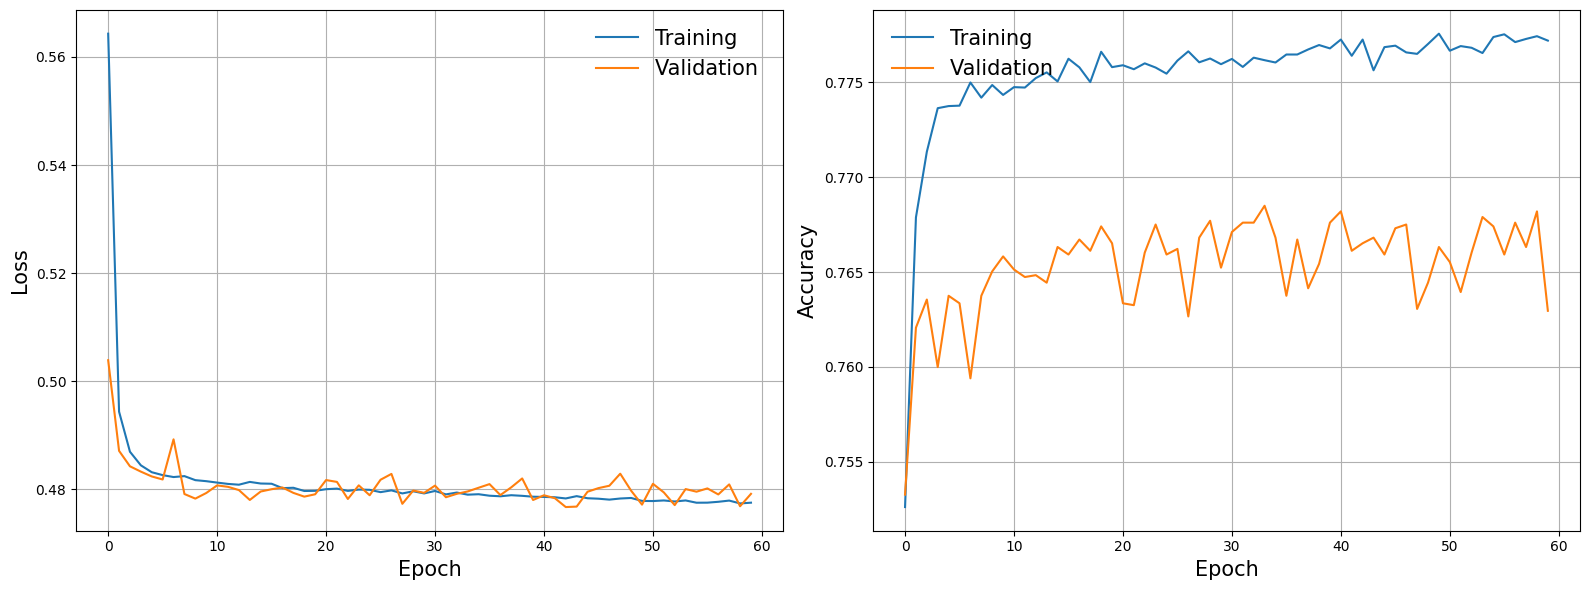

In [34]:
draw_metric_evolution()



Now let's evaluate how our model performs on the validation dataset by calculating accuracy for each jet type and building the ROC curve.



In [35]:
pred_val = []
pred_label = []
true_label = []
for i, data in enumerate(jets_loader_val):
    inputs, labels = data, data.y
    inputs = inputs.to(device)
    # there is no softmax in the output layer. We have to put it. 
    pred_val.append(F.softmax(gnn(inputs.to(device)), dim=1).cpu().detach().numpy())
    pred_label.append(np.argmax(pred_val[i],axis=1))
    true_label.append(labels.numpy())
pred_val = np.concatenate(pred_val, axis=0)
pred_label = np.concatenate(pred_label, axis=0)
true_label = np.concatenate(true_label,axis=0)

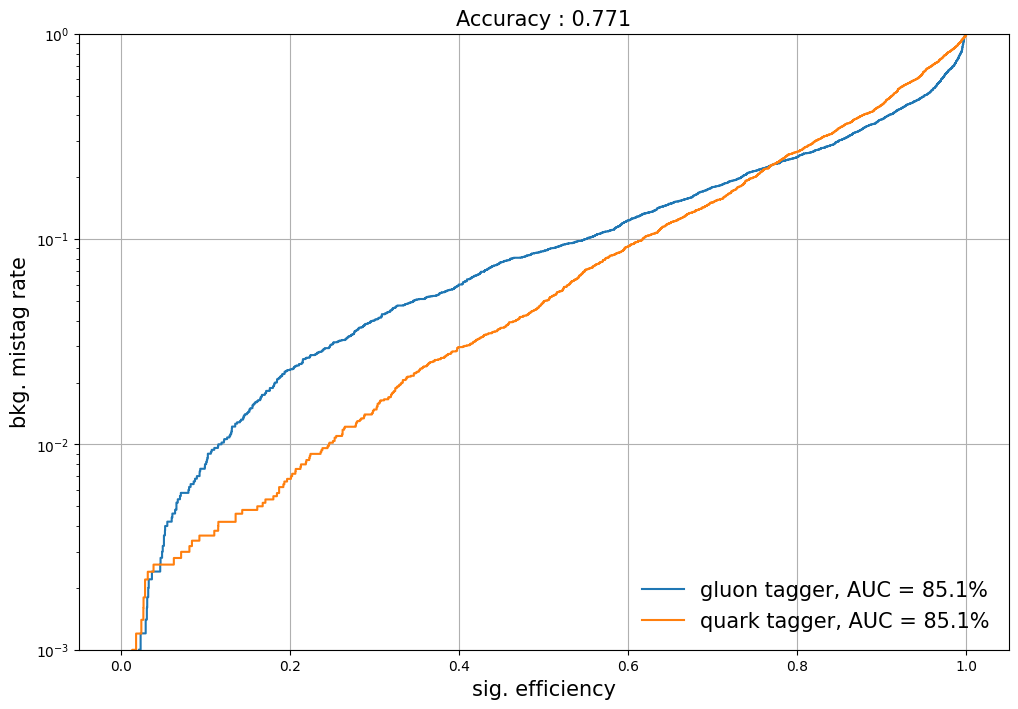

In [36]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#### get the ROC curves
fpr = {}
tpr = {}
auc_value = {}
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    fpr[label], tpr[label], threshold = roc_curve((true_label== i), pred_val[:,i])
    auc_value[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label,auc_value[label]*100.))
#computing accuracy now
acc_score = accuracy_score(true_label, pred_label)
acc_manual = np.sum(pred_label == true_label)
plt.title('Accuracy : {:.3f}'.format(acc_score), fontsize=15)
plt.semilogy()
plt.xlabel("sig. efficiency",fontsize=15)
plt.ylabel("bkg. mistag rate",fontsize=15)
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=15, frameon=False)
plt.show()

Now let's evaluate confusion matrix

In [186]:
# First we define a helper function
import seaborn as sns
sns.set_style("whitegrid")

def plot_matrix(cm, classes, title):
  plt.figure(figsize = (12,12))  
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title=title, xlabel="Predicted label", ylabel="True label")

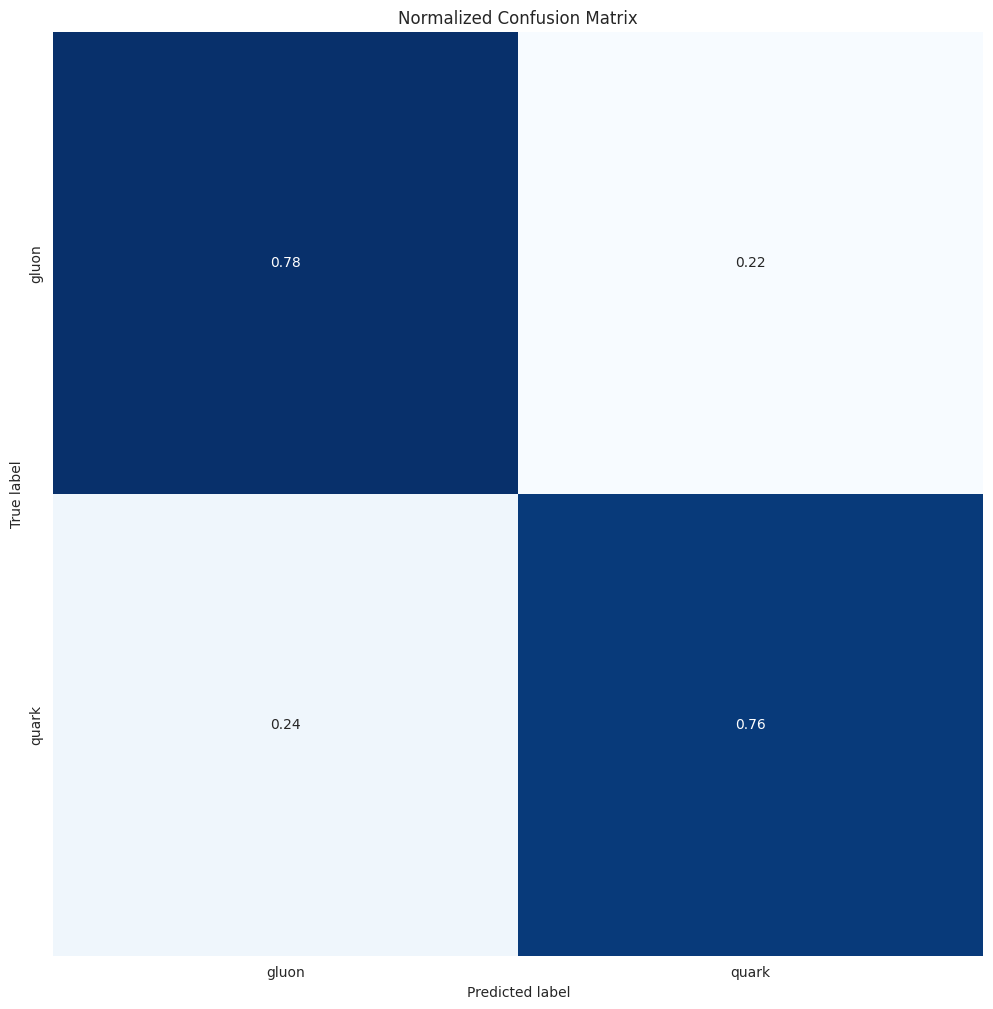

In [38]:
#Evaluate confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_label, pred_label,normalize = 'true')
plot_matrix(cm, label_names, title = 'Normalized Confusion Matrix')

We can see that overall performance is not bad!

## LorentzNet

Now, let's look at the performance of LorentzNet on our dataset. Before, I projected only the first three features to the point-cloud, as a simpler test, but given the pt, rapidity, azimuthal_angle and the particle id, we can retrieve a more complete information, like its four-momentum, and also associated scalars, like its mass and charge, or particle id.

Here, each jet is denoted as a graph consisting of an unordered set of nodes (particles), where each node is considered a point-cloud living in $\mathbb{R}^{4}$. Each jet can have different number of constituent particles, and the LorentzNet is built upon the universal approximation theorem for Lorentz-equivariant functions. This is the sketched out architecture:

<img src="figures/LorentzNet.png" width=65% style="margin-left:auto; margin-right:auto">

The **input layer** consists of four-momentum vectors of particles from a collision event, and the input is a set of vectors $f_i = v_i \mathop{\bigoplus} s_i$, where $f_i = \{E_i, p_{x_i}, p_{y_i}, p_{z_i}\}$ is the four-momentum vector for particle $i$, and $s_i$ is a set of scalars for particle $i$, like mass, charge, particle id. 

Now, the **Lorentz Group Equivariant Block** (LGEB) constitutes of $\phi_{e}(x), \phi_{h}(x), \phi_{x}(x)$, which are continuous functions modeled by neural networks, where $\phi_{e}(x)$ is responsible for computing the edge message between particles $i$ and $j$ for the $l$-th layer via:

\begin{equation}
m_{ij}^{l} = \phi_{e}(h_i, h_j, \psi(||x_{i}^{l} - x_{j}^{l}||^2), \psi(\langle x_{i}, x_{j}\rangle)),
\end{equation}

and $\psi(\cdot) = sgn(\cdot)log(|\cdot| + 1)$ is just a function to normalize large numbers from different distributions, making optimization easier. Now, $\phi_{x}(x)$ is the responsible for the Minkowski dot product attention, which is proposed in the paper as:

\begin{equation}
x_{i}^{l+1} = x_{i}^{l} + c\sum_{j\in\mathcal{N}(i)}\phi_{x}(m_{ij}^{j})\cdot x_{j}^{l},
\end{equation}

so the feature for each particle in the next layer is the feature for the current layer and a weighted feature sum of neighboring particles \mathcal{N}(i), where the weights depend on each edge message calculated before and $c$, which is just a scalar to control the scale again. Finally, $\phi_{h}(x)$ updates the scalar features for particle $i$ as:

\begin{equation}
h_{i}^{l+1} = h_{i}^{l} + \phi_{h}(h_{i}^{l}, \sum_{j\in\mathcal{N}(i)}w_{ij}m_{ij}),
\end{equation}

where $w_{ij}$ learns the edge significance between particle $i$ and $j$ through again another neural network $\phi_{m}(m_{ij}^{l}) \in [0, 1]$ . It's important to note that the initial scalar features $h_{i}^{0}$ are embedded into deeper representations through the layers, and since the **edge message $m_{ij}$** contains information about **both** **$x_{i}$** and **$x_{j}$**, in the very end, if you look into the diagram, you'll see that only **$h^{l}$** is returned, a clever trick to avoid redundancy.


Lastly, given the transversal momentum **$p_{T}$**, pseudo-rapidity **$\eta$**, and azimuthal angle **$\phi$** and the particle id, it is possible to retrieve the 4-momenta for each particle. The energyflow package facilitates this, so, in the code, this is the first thing done to retrieve our dataset.


I am going to use the official implementation from the Author's GitHub here: https://github.com/sdogsq/LorentzNet-release/tree/maine/tree/main

In [84]:
import torch
import numpy as np
import energyflow
from scipy.sparse import coo_matrix
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data.distributed import DistributedSampler

def get_adj_matrix(n_nodes, batch_size, edge_mask):
    rows, cols = [], []
    for batch_idx in range(batch_size):
        nn = batch_idx*n_nodes
        x = coo_matrix(edge_mask[batch_idx])
        rows.append(nn + x.row)
        cols.append(nn + x.col)
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)

    edges = [torch.LongTensor(rows), torch.LongTensor(cols)]
    return edges

def collate_fn(data):
    data = list(zip(*data)) # label p4s nodes atom_mask
    data = [torch.stack(item) for item in data]
    batch_size, n_nodes, _ = data[1].size()
    atom_mask = data[-1]
    edge_mask = atom_mask.unsqueeze(1) * atom_mask.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask *= diag_mask
    edges = get_adj_matrix(n_nodes, batch_size, edge_mask)
    return data + [edge_mask, edges]

def retrieve_dataloaders(batch_size, num_data = -1, use_one_hot = True, cache_dir = './data', num_workers=4):
    raw = energyflow.qg_jets.load(num_data=num_data, pad=True, ncol=4, generator='pythia',
                            with_bc=False, cache_dir=cache_dir)
    splits = ['train', 'val', 'test']
    data = {type:{'raw':None,'label':None} for type in splits}
    (data['train']['raw'],  data['val']['raw'],   data['test']['raw'],
    data['train']['label'], data['val']['label'], data['test']['label']) = \
        energyflow.utils.data_split(*raw, train=0.8, val=0.1, test=0.1, shuffle = False)

    enc = OneHotEncoder(handle_unknown='ignore').fit([[11],[13],[22],[130],[211],[321],[2112],[2212]])
    
    for split, value in data.items():
        pid = torch.from_numpy(np.abs(np.asarray(value['raw'][...,3], dtype=int))).unsqueeze(-1)
        p4s = torch.from_numpy(energyflow.p4s_from_ptyphipids(value['raw'],error_on_unknown=True))
        one_hot = enc.transform(pid.reshape(-1,1)).toarray().reshape(pid.shape[:2]+(-1,))
        one_hot = torch.from_numpy(one_hot)
        mass = torch.from_numpy(energyflow.ms_from_p4s(p4s)).unsqueeze(-1)
        charge = torch.from_numpy(energyflow.pids2chrgs(pid))
        if use_one_hot:
            nodes = one_hot
        else:
            nodes = torch.cat((mass,charge),dim=-1)
            nodes = torch.sign(nodes) * torch.log(torch.abs(nodes) + 1)
        atom_mask = (pid[...,0] != 0)
        value['p4s'] = p4s
        value['nodes'] = nodes
        value['label'] = torch.from_numpy(value['label'])
        value['atom_mask'] = atom_mask.to(torch.bool)

    datasets = {split: TensorDataset(value['label'], value['p4s'],
                                     value['nodes'], value['atom_mask'])
                for split, value in data.items()}

    # distributed training
    # train_sampler = DistributedSampler(datasets['train'], shuffle=True)
    # Construct PyTorch dataloaders from datasets
    dataloaders = {split: DataLoader(dataset,
                                     batch_size=batch_size,
                                     # sampler=train_sampler if (split == 'train') else DistributedSampler(dataset, shuffle=False),
                                     pin_memory=True,
                                     # persistent_workers=True,
                                     drop_last=True if (split == 'train') else False,
                                     num_workers=num_workers,
                                     collate_fn=collate_fn)
                        for split, dataset in datasets.items()}

    return dataloaders #train_sampler, dataloaders

if __name__ == '__main__':
    # train_sampler, dataloaders = retrieve_dataloaders(32, 100)
    dataloaders = retrieve_dataloaders(32, 100)
    for (label, p4s, nodes, atom_mask, edge_mask, edges) in dataloaders['train']:
        print(label.shape, p4s.shape, nodes.shape, atom_mask.shape,
              edge_mask.shape, edges[0].shape, edges[1].shape)
        break

torch.Size([32]) torch.Size([32, 139, 4]) torch.Size([32, 139, 8]) torch.Size([32, 139]) torch.Size([32, 139, 139]) torch.Size([64608]) torch.Size([64608])


## Let's now define our model

In [85]:
import torch
from torch import nn
import numpy as np

class LGEB(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_node_attr=0,
                 dropout = 0., c_weight=1.0, last_layer=False, A=None, include_x=False):
        super(LGEB, self).__init__()
        self.c_weight = c_weight
        n_edge_attr = 2 if not include_x else 10 # dims for Minkowski norm & inner product

        self.include_x = include_x
        self.phi_e = nn.Sequential(
            nn.Linear(n_input * 2 + n_edge_attr, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU())

        self.phi_h = nn.Sequential(
            nn.Linear(n_hidden + n_input + n_node_attr, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output))

        layer = nn.Linear(n_hidden, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.phi_x = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            layer)

        self.phi_m = nn.Sequential(
            nn.Linear(n_hidden, 1),
            nn.Sigmoid())
        
        self.last_layer = last_layer
        if last_layer:
            del self.phi_x

        self.A = A
        self.norm_fn = normA_fn(A) if A is not None else normsq4
        self.dot_fn = dotA_fn(A) if A is not None else dotsq4

    def m_model(self, hi, hj, norms, dots):
        out = torch.cat([hi, hj, norms, dots], dim=1)
        out = self.phi_e(out)
        w = self.phi_m(out)
        out = out * w
        return out

    def m_model_extended(self, hi, hj, norms, dots, xi, xj):
        out = torch.cat([hi, hj, norms, dots, xi, xj], dim=1)
        out = self.phi_e(out)
        w = self.phi_m(out)
        out = out * w
        return out

    def h_model(self, h, edges, m, node_attr):
        i, j = edges
        agg = unsorted_segment_sum(m, i, num_segments=h.size(0))
        agg = torch.cat([h, agg, node_attr], dim=1)
        out = h + self.phi_h(agg)
        return out

    def x_model(self, x, edges, x_diff, m):
        i, j = edges
        trans = x_diff * self.phi_x(m)
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, i, num_segments=x.size(0))
        x = x + agg * self.c_weight
        return x

    def minkowski_feats(self, edges, x):
        i, j = edges
        x_diff = x[i] - x[j]
        norms = self.norm_fn(x_diff).unsqueeze(1)
        dots = self.dot_fn(x[i], x[j]).unsqueeze(1)
        norms, dots = psi(norms), psi(dots)
        return norms, dots, x_diff

    def forward(self, h, x, edges, node_attr=None):
        i, j = edges
        norms, dots, x_diff = self.minkowski_feats(edges, x)

        if self.include_x:
            m = self.m_model_extended(h[i], h[j], norms, dots, x[i], x[j])
        else:
            m = self.m_model(h[i], h[j], norms, dots) # [B*N, hidden]
        if not self.last_layer:
            x = self.x_model(x, edges, x_diff, m)
        h = self.h_model(h, edges, m, node_attr)
        return h, x, m

class LorentzNet(nn.Module):
    r''' Implementation of LorentzNet.

    Args:
        - `n_scalar` (int): number of input scalars.
        - `n_hidden` (int): dimension of latent space.
        - `n_class`  (int): number of output classes.
        - `n_layers` (int): number of LGEB layers.
        - `c_weight` (float): weight c in the x_model.
        - `dropout`  (float): dropout rate.
    '''
    def __init__(self, n_scalar, n_hidden, n_class = 2, n_layers = 6, c_weight = 1e-3, dropout = 0., A=None, include_x=False):
        super(LorentzNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Linear(n_scalar, n_hidden)
        self.LGEBs = nn.ModuleList([LGEB(self.n_hidden, self.n_hidden, self.n_hidden, 
                                    n_node_attr=n_scalar, dropout=dropout,
                                    c_weight=c_weight, last_layer=(i==n_layers-1), A=A, include_x=include_x)
                                    for i in range(n_layers)])
        self.graph_dec = nn.Sequential(nn.Linear(self.n_hidden, self.n_hidden),
                                       nn.ReLU(),
                                       nn.Dropout(dropout),
                                       nn.Linear(self.n_hidden, n_class)) # classification

    def forward(self, scalars, x, edges, node_mask, edge_mask, n_nodes):
        h = self.embedding(scalars)

        for i in range(self.n_layers):
            # print(i)
            h, x, _ = self.LGEBs[i](h, x, edges, node_attr=scalars)

        h = h * node_mask
        h = h.view(-1, n_nodes, self.n_hidden)
        h = torch.mean(h, dim=1)
        pred = self.graph_dec(h)
        return pred.squeeze(1)


def unsorted_segment_sum(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_mean`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    count.index_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def normsq4(p):
    r''' Minkowski square norm
         `\|p\|^2 = p[0]^2-p[1]^2-p[2]^2-p[3]^2`
    ''' 
    psq = torch.pow(p, 2)
    return 2 * psq[..., 0] - psq.sum(dim=-1)
    
def dotsq4(p,q):
    r''' Minkowski inner product
         `<p,q> = p[0]q[0]-p[1]q[1]-p[2]q[2]-p[3]q[3]`
    '''
    psq = p*q
    return 2 * psq[..., 0] - psq.sum(dim=-1)

def normA_fn(A):
    return lambda p: torch.einsum('...i, ij, ...j->...', p, A, p)

def dotA_fn(A):
    return lambda p, q: torch.einsum('...i, ij, ...j->...', p, A, q)
    
def psi(p):
    ''' `\psi(p) = Sgn(p) \cdot \log(|p| + 1)`
    '''
    return torch.sign(p) * torch.log(torch.abs(p) + 1)

In [191]:
model_summary(LorentzNet(n_scalar = 8, n_hidden = 72, n_class = 2,\
                       dropout = 0.2, n_layers = 6,\
                       c_weight = 1e-3))

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
    embedding.weight                    [72, 8]             576
      embedding.bias                       [72]              72
LGEBs.0.phi_e.0.weight                  [72, 146]           10512
LGEBs.0.phi_e.1.weight                       [72]              72
LGEBs.0.phi_e.1.bias                       [72]              72
LGEBs.0.phi_e.3.weight                   [72, 72]            5184
LGEBs.0.phi_e.3.bias                       [72]              72
LGEBs.0.phi_h.0.weight                  [72, 152]           10944
LGEBs.0.phi_h.0.bias                       [72]              72
LGEBs.0.phi_h.1.weight                       [72]              72
LGEBs.0.phi_h.1.bias                       [72]              72
LGEBs.0.phi_h.3.weight                   [72, 72]            5184
LGEBs.0.phi_h.3.bias      

### ParticleNet had 409666 total params...

...And now we have a model half the size of the first. Of course, the features used will be different now, since we have a specific inductive bias, but let's see what happens

## and our training function

In [140]:
import torch
from torch import nn, optim
import json, time
import utils_lorentz
import numpy as np
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from tqdm import tqdm

def run(epoch, loader, partition, N_EPOCHS=None):
    if partition == 'train':
        model.train()
    else:
        model.eval()

    res = {'time':0, 'correct':0, 'loss': 0, 'counter': 0, 'acc': 0,
           'loss_arr':[], 'correct_arr':[],'label':[],'score':[]}

    tik = time.time()
    loader_length = len(loader)

    for i, (label, p4s, nodes, atom_mask, edge_mask, edges) in tqdm(enumerate(loader)):
        if partition == 'train':
            optimizer.zero_grad()

        batch_size, n_nodes, _ = p4s.size()
        atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
        atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device)
        edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device)
        nodes = nodes.view(batch_size * n_nodes, -1).to(device,dtype)
        edges = [a.to(device) for a in edges]
        label = label.to(device, dtype).long()

        pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                         edge_mask=edge_mask, n_nodes=n_nodes)
        
        predict = pred.max(1).indices
        correct = torch.sum(predict == label).item()
        loss = loss_fn(pred, label)
        
        if partition == 'train':
            loss.backward()
            optimizer.step()
        elif partition == 'test':
            # save labels and probilities for ROC / AUC
            # print("Preds ", pred)
            score = torch.nn.functional.softmax(pred, dim = -1)
            # print("Score test ", score)
            # raise
            res['label'].append(label)
            res['score'].append(score)

        res['time'] = time.time() - tik
        res['correct'] += correct
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
        res['loss_arr'].append(loss.item())
        res['correct_arr'].append(correct)

        # if i != 0 and i % args.log_interval == 0:
        
    running_loss = sum(res['loss_arr'])/len(res['loss_arr'])
    running_acc = sum(res['correct_arr'])/(len(res['correct_arr'])*batch_size)
    avg_time = res['time']/res['counter'] * batch_size
    tmp_counter = res['counter']
    tmp_loss = res['loss'] / tmp_counter
    tmp_acc = res['correct'] / tmp_counter

    if N_EPOCHS:
        print(">> %s \t Epoch %d/%d \t Batch %d/%d \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, epoch + 1, N_EPOCHS, i, loader_length, running_loss, running_acc, tmp_acc, avg_time))
    else:
        print(">> %s \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, running_loss, running_acc, tmp_acc, avg_time))
        
    torch.cuda.empty_cache()
    # ---------- reduce -----------
    if partition == 'test':
        res['label'] = torch.cat(res['label']).unsqueeze(-1)
        res['score'] = torch.cat(res['score'])
        res['score'] = torch.cat((res['label'],res['score']),dim=-1)
    res['counter'] = res['counter']
    res['loss'] = res['loss'] / res['counter']
    res['acc'] = res['correct'] / res['counter']
    return res

def train(res, N_EPOCHS):
    ### training and validation
    for epoch in range(N_EPOCHS):
        train_res = run(epoch, dataloaders['train'], partition='train', N_EPOCHS = N_EPOCHS)
        print("Time: train: %.2f \t Train loss %.4f \t Train acc: %.4f" % (train_res['time'],train_res['loss'],train_res['acc']))
        # if epoch % args.val_interval == 0:
            
        # if (args.local_rank == 0):
        torch.save(model.state_dict(), "models/CMS_task_iii_g/checkpoint-epoch-{}.pt".format(epoch))
        with torch.no_grad():
            val_res = run(epoch, dataloaders['val'], partition='val')
            
        # if (args.local_rank == 0): # only master process save
        res['lr'].append(optimizer.param_groups[0]['lr'])
        res['train_time'].append(train_res['time'])
        res['val_time'].append(val_res['time'])
        res['train_loss'].append(train_res['loss'])
        res['train_acc'].append(train_res['acc'])
        res['val_loss'].append(val_res['loss'])
        res['val_acc'].append(val_res['acc'])
        res['epochs'].append(epoch)

        ## save best model
        if val_res['acc'] > res['best_val']:
            print("New best validation model, saving...")
            torch.save(model.state_dict(), "models/CMS_task_iii_g/best-val-model.pt")
            res['best_val'] = val_res['acc']
            res['best_epoch'] = epoch

        print("Epoch %d/%d finished." % (epoch, N_EPOCHS))
        print("Train time: %.2f \t Val time %.2f" % (train_res['time'], val_res['time']))
        print("Train loss %.4f \t Train acc: %.4f" % (train_res['loss'], train_res['acc']))
        print("Val loss: %.4f \t Val acc: %.4f" % (val_res['loss'], val_res['acc']))
        print("Best val acc: %.4f at epoch %d." % (res['best_val'],  res['best_epoch']))

        json_object = json.dumps(res, indent=4)
        with open("logs/CMS_task_iii_g/train-result-epoch{}.json".format(epoch), "w") as outfile:
            outfile.write(json_object)

        ## adjust learning rate
        if (epoch < 31):
            lr_scheduler.step(metrics=val_res['acc'])
        else:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.5


def test(res):
    ### test on best model
    best_model = torch.load("models/CMS_task_iii_g/best-val-model.pt", map_location=device)
    model.load_state_dict(best_model)
    with torch.no_grad():
        test_res = run(0, dataloaders['test'], partition='test')

    print("Final ", test_res['score'])
    pred = test_res['score'].cpu()

    np.save("logs/CMS_task_iii_g/score.npy",pred)
    fpr, tpr, thres, eB, eS  = utils_lorentz.buildROC(pred[...,0], pred[...,2])
    auc = utils_lorentz.roc_auc_score(pred[...,0], pred[...,2])

    metric = {'test_loss': test_res['loss'], 'test_acc': test_res['acc'],
              'test_auc': auc, 'test_1/eB_0.3':1./eB[0],'test_1/eB_0.5':1./eB[1]}
    res.update(metric)
    print("Test: Loss %.4f \t Acc %.4f \t AUC: %.4f \t 1/eB 0.3: %.4f \t 1/eB 0.5: %.4f"\
           % (test_res['loss'], test_res['acc'], auc, 1./eB[0], 1./eB[1]))
    json_object = json.dumps(res, indent=4)
    with open("logs/CMS_task_iii_g/test-result.json", "w") as outfile:
        outfile.write(json_object)

if __name__ == "__main__":
    
    N_EPOCHS = 60

    # utils_lorentz.args_init(args)

    ### set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    ### initialize cuda
    # dist.init_process_group(backend='nccl')
    device = torch.device("cuda")
    dtype = torch.float32

    ### load data
    dataloaders = retrieve_dataloaders( batch_size,
                                        num_data=100000, # use all data
                                        cache_dir="datasets/QMLHEP/quark_gluons/",
                                        num_workers=0,
                                        use_one_hot=True)

    ### create parallel model
    model = LorentzNet(n_scalar = 8, n_hidden = 72, n_class = 2,\
                       dropout = 0.2, n_layers = 6,\
                       c_weight = 1e-3)
    
    model = model.to(device)

    ### print model and dataset information
    # if (args.local_rank == 0):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Model Size:", pytorch_total_params)
    for (split, dataloader) in dataloaders.items():
        print(f" {split} samples: {len(dataloader.dataset)}")

    ### optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

    ### lr scheduler
    base_scheduler = CosineAnnealingWarmRestarts(optimizer, 4, 2, verbose = False)
    lr_scheduler = utils_lorentz.GradualWarmupScheduler(optimizer, multiplier=1,\
                                                warmup_epoch=5,\
                                                after_scheduler=base_scheduler) ## warmup

    ### loss function
    loss_fn = nn.CrossEntropyLoss()

    ### initialize logs
    res = {'epochs': [], 'lr' : [],\
           'train_time': [], 'val_time': [],  'train_loss': [], 'val_loss': [],\
           'train_acc': [], 'val_acc': [], 'best_val': 0, 'best_epoch': 0}

    ### training and testing
    print("Training...")
    train(res, N_EPOCHS)
    test(res)

/home/jogi/anaconda3/envs/ml4sci/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model Size: 227096
 train samples: 80000
 val samples: 10000
 test samples: 10000
Training...


625it [02:09,  4.84it/s]


>> train 	 Epoch 1/60 	 Batch 624/625 	 Loss 0.4700 	 Running Acc 0.785 	 Total Acc 0.785 	 Avg Batch Time 0.2066
Time: train: 129.12 	 Train loss 0.4700 	 Train acc: 0.7852


79it [00:08,  9.51it/s]


>> val 	 Loss 0.4668 	 Running Acc 6.202 	 Total Acc 0.784 	 Avg Batch Time 0.0133
New best validation model, saving...
Epoch 0/60 finished.
Train time: 129.12 	 Val time 8.31
Train loss 0.4700 	 Train acc: 0.7852
Val loss: 0.4672 	 Val acc: 0.7839
Best val acc: 0.7839 at epoch 0.


625it [02:09,  4.82it/s]


>> train 	 Epoch 2/60 	 Batch 624/625 	 Loss 0.4564 	 Running Acc 0.792 	 Total Acc 0.792 	 Avg Batch Time 0.2074
Time: train: 129.62 	 Train loss 0.4564 	 Train acc: 0.7916


79it [00:08,  9.53it/s]


>> val 	 Loss 0.4550 	 Running Acc 6.265 	 Total Acc 0.792 	 Avg Batch Time 0.0133
New best validation model, saving...
Epoch 1/60 finished.
Train time: 129.62 	 Val time 8.29
Train loss 0.4564 	 Train acc: 0.7916
Val loss: 0.4558 	 Val acc: 0.7919
Best val acc: 0.7919 at epoch 1.


625it [02:18,  4.52it/s]


>> train 	 Epoch 3/60 	 Batch 624/625 	 Loss 0.4512 	 Running Acc 0.795 	 Total Acc 0.795 	 Avg Batch Time 0.2209
Time: train: 138.09 	 Train loss 0.4512 	 Train acc: 0.7948


79it [00:09,  8.60it/s]


>> val 	 Loss 0.4516 	 Running Acc 6.283 	 Total Acc 0.794 	 Avg Batch Time 0.0147
New best validation model, saving...
Epoch 2/60 finished.
Train time: 138.09 	 Val time 9.18
Train loss 0.4512 	 Train acc: 0.7948
Val loss: 0.4523 	 Val acc: 0.7942
Best val acc: 0.7942 at epoch 2.


625it [02:22,  4.39it/s]


>> train 	 Epoch 4/60 	 Batch 624/625 	 Loss 0.4484 	 Running Acc 0.796 	 Total Acc 0.796 	 Avg Batch Time 0.2275
Time: train: 142.17 	 Train loss 0.4484 	 Train acc: 0.7961


79it [00:09,  8.74it/s]


>> val 	 Loss 0.4556 	 Running Acc 6.277 	 Total Acc 0.793 	 Avg Batch Time 0.0145
Epoch 3/60 finished.
Train time: 142.17 	 Val time 9.04
Train loss 0.4484 	 Train acc: 0.7961
Val loss: 0.4565 	 Val acc: 0.7934
Best val acc: 0.7942 at epoch 2.


625it [02:22,  4.40it/s]


>> train 	 Epoch 5/60 	 Batch 624/625 	 Loss 0.4478 	 Running Acc 0.797 	 Total Acc 0.797 	 Avg Batch Time 0.2273
Time: train: 142.09 	 Train loss 0.4478 	 Train acc: 0.7967


79it [00:09,  8.66it/s]


>> val 	 Loss 0.4558 	 Running Acc 6.250 	 Total Acc 0.790 	 Avg Batch Time 0.0146
Epoch 4/60 finished.
Train time: 142.09 	 Val time 9.12
Train loss 0.4478 	 Train acc: 0.7967
Val loss: 0.4565 	 Val acc: 0.7900
Best val acc: 0.7942 at epoch 2.


625it [02:22,  4.39it/s]


>> train 	 Epoch 6/60 	 Batch 624/625 	 Loss 0.4439 	 Running Acc 0.798 	 Total Acc 0.798 	 Avg Batch Time 0.2275
Time: train: 142.20 	 Train loss 0.4439 	 Train acc: 0.7984


79it [00:09,  8.72it/s]


>> val 	 Loss 0.4474 	 Running Acc 6.286 	 Total Acc 0.795 	 Avg Batch Time 0.0145
New best validation model, saving...
Epoch 5/60 finished.
Train time: 142.20 	 Val time 9.06
Train loss 0.4439 	 Train acc: 0.7984
Val loss: 0.4482 	 Val acc: 0.7946
Best val acc: 0.7946 at epoch 5.


625it [02:22,  4.38it/s]


>> train 	 Epoch 7/60 	 Batch 624/625 	 Loss 0.4393 	 Running Acc 0.801 	 Total Acc 0.801 	 Avg Batch Time 0.2281
Time: train: 142.57 	 Train loss 0.4393 	 Train acc: 0.8009


79it [00:09,  8.46it/s]


>> val 	 Loss 0.4481 	 Running Acc 6.290 	 Total Acc 0.795 	 Avg Batch Time 0.0149
New best validation model, saving...
Epoch 6/60 finished.
Train time: 142.57 	 Val time 9.34
Train loss 0.4393 	 Train acc: 0.8009
Val loss: 0.4489 	 Val acc: 0.7950
Best val acc: 0.7950 at epoch 6.


625it [02:22,  4.38it/s]


>> train 	 Epoch 8/60 	 Batch 624/625 	 Loss 0.4350 	 Running Acc 0.803 	 Total Acc 0.803 	 Avg Batch Time 0.2280
Time: train: 142.50 	 Train loss 0.4350 	 Train acc: 0.8028


79it [00:09,  8.66it/s]


>> val 	 Loss 0.4424 	 Running Acc 6.318 	 Total Acc 0.799 	 Avg Batch Time 0.0146
New best validation model, saving...
Epoch 7/60 finished.
Train time: 142.50 	 Val time 9.12
Train loss 0.4350 	 Train acc: 0.8028
Val loss: 0.4434 	 Val acc: 0.7986
Best val acc: 0.7986 at epoch 7.


625it [02:22,  4.39it/s]


>> train 	 Epoch 9/60 	 Batch 624/625 	 Loss 0.4436 	 Running Acc 0.799 	 Total Acc 0.799 	 Avg Batch Time 0.2277
Time: train: 142.31 	 Train loss 0.4436 	 Train acc: 0.7993


79it [00:09,  8.56it/s]


>> val 	 Loss 0.4493 	 Running Acc 6.289 	 Total Acc 0.795 	 Avg Batch Time 0.0148
Epoch 8/60 finished.
Train time: 142.31 	 Val time 9.23
Train loss 0.4436 	 Train acc: 0.7993
Val loss: 0.4502 	 Val acc: 0.7949
Best val acc: 0.7986 at epoch 7.


625it [02:22,  4.39it/s]


>> train 	 Epoch 10/60 	 Batch 624/625 	 Loss 0.4409 	 Running Acc 0.801 	 Total Acc 0.801 	 Avg Batch Time 0.2279
Time: train: 142.44 	 Train loss 0.4409 	 Train acc: 0.8011


79it [00:09,  8.70it/s]


>> val 	 Loss 0.4479 	 Running Acc 6.289 	 Total Acc 0.795 	 Avg Batch Time 0.0145
Epoch 9/60 finished.
Train time: 142.44 	 Val time 9.08
Train loss 0.4409 	 Train acc: 0.8011
Val loss: 0.4487 	 Val acc: 0.7949
Best val acc: 0.7986 at epoch 7.


625it [02:22,  4.39it/s]


>> train 	 Epoch 11/60 	 Batch 624/625 	 Loss 0.4373 	 Running Acc 0.802 	 Total Acc 0.802 	 Avg Batch Time 0.2275
Time: train: 142.20 	 Train loss 0.4373 	 Train acc: 0.8023


79it [00:09,  8.67it/s]


>> val 	 Loss 0.4456 	 Running Acc 6.298 	 Total Acc 0.796 	 Avg Batch Time 0.0146
Epoch 10/60 finished.
Train time: 142.20 	 Val time 9.12
Train loss 0.4373 	 Train acc: 0.8023
Val loss: 0.4463 	 Val acc: 0.7961
Best val acc: 0.7986 at epoch 7.


625it [02:22,  4.38it/s]


>> train 	 Epoch 12/60 	 Batch 624/625 	 Loss 0.4343 	 Running Acc 0.805 	 Total Acc 0.805 	 Avg Batch Time 0.2281
Time: train: 142.54 	 Train loss 0.4343 	 Train acc: 0.8046


79it [00:09,  8.61it/s]


>> val 	 Loss 0.4451 	 Running Acc 6.290 	 Total Acc 0.795 	 Avg Batch Time 0.0147
Epoch 11/60 finished.
Train time: 142.54 	 Val time 9.18
Train loss 0.4343 	 Train acc: 0.8046
Val loss: 0.4457 	 Val acc: 0.7950
Best val acc: 0.7986 at epoch 7.


625it [02:22,  4.40it/s]


>> train 	 Epoch 13/60 	 Batch 624/625 	 Loss 0.4305 	 Running Acc 0.806 	 Total Acc 0.806 	 Avg Batch Time 0.2272
Time: train: 142.00 	 Train loss 0.4305 	 Train acc: 0.8059


79it [00:09,  8.71it/s]


>> val 	 Loss 0.4406 	 Running Acc 6.326 	 Total Acc 0.800 	 Avg Batch Time 0.0145
New best validation model, saving...
Epoch 12/60 finished.
Train time: 142.00 	 Val time 9.07
Train loss 0.4305 	 Train acc: 0.8059
Val loss: 0.4411 	 Val acc: 0.7996
Best val acc: 0.7996 at epoch 12.


625it [02:21,  4.41it/s]


>> train 	 Epoch 14/60 	 Batch 624/625 	 Loss 0.4265 	 Running Acc 0.809 	 Total Acc 0.809 	 Avg Batch Time 0.2268
Time: train: 141.76 	 Train loss 0.4265 	 Train acc: 0.8092


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4355 	 Running Acc 6.363 	 Total Acc 0.804 	 Avg Batch Time 0.0146
New best validation model, saving...
Epoch 13/60 finished.
Train time: 141.76 	 Val time 9.10
Train loss 0.4265 	 Train acc: 0.8092
Val loss: 0.4364 	 Val acc: 0.8043
Best val acc: 0.8043 at epoch 13.


625it [02:22,  4.39it/s]


>> train 	 Epoch 15/60 	 Batch 624/625 	 Loss 0.4222 	 Running Acc 0.811 	 Total Acc 0.811 	 Avg Batch Time 0.2275
Time: train: 142.21 	 Train loss 0.4222 	 Train acc: 0.8106


79it [00:09,  8.69it/s]


>> val 	 Loss 0.4335 	 Running Acc 6.370 	 Total Acc 0.805 	 Avg Batch Time 0.0145
New best validation model, saving...
Epoch 14/60 finished.
Train time: 142.21 	 Val time 9.09
Train loss 0.4222 	 Train acc: 0.8106
Val loss: 0.4346 	 Val acc: 0.8052
Best val acc: 0.8052 at epoch 14.


625it [02:22,  4.38it/s]


>> train 	 Epoch 16/60 	 Batch 624/625 	 Loss 0.4188 	 Running Acc 0.813 	 Total Acc 0.813 	 Avg Batch Time 0.2284
Time: train: 142.76 	 Train loss 0.4188 	 Train acc: 0.8132


79it [00:09,  8.69it/s]


>> val 	 Loss 0.4288 	 Running Acc 6.371 	 Total Acc 0.805 	 Avg Batch Time 0.0145
New best validation model, saving...
Epoch 15/60 finished.
Train time: 142.76 	 Val time 9.09
Train loss 0.4188 	 Train acc: 0.8132
Val loss: 0.4302 	 Val acc: 0.8053
Best val acc: 0.8053 at epoch 15.


625it [02:21,  4.40it/s]


>> train 	 Epoch 17/60 	 Batch 624/625 	 Loss 0.4310 	 Running Acc 0.807 	 Total Acc 0.807 	 Avg Batch Time 0.2269
Time: train: 141.84 	 Train loss 0.4310 	 Train acc: 0.8070


79it [00:09,  8.66it/s]


>> val 	 Loss 0.4390 	 Running Acc 6.332 	 Total Acc 0.800 	 Avg Batch Time 0.0146
Epoch 16/60 finished.
Train time: 141.84 	 Val time 9.13
Train loss 0.4310 	 Train acc: 0.8070
Val loss: 0.4399 	 Val acc: 0.8004
Best val acc: 0.8053 at epoch 15.


625it [02:22,  4.40it/s]


>> train 	 Epoch 18/60 	 Batch 624/625 	 Loss 0.4299 	 Running Acc 0.808 	 Total Acc 0.808 	 Avg Batch Time 0.2272
Time: train: 142.01 	 Train loss 0.4299 	 Train acc: 0.8075


79it [00:09,  8.74it/s]


>> val 	 Loss 0.4364 	 Running Acc 6.327 	 Total Acc 0.800 	 Avg Batch Time 0.0145
Epoch 17/60 finished.
Train time: 142.01 	 Val time 9.04
Train loss 0.4299 	 Train acc: 0.8075
Val loss: 0.4374 	 Val acc: 0.7997
Best val acc: 0.8053 at epoch 15.


625it [02:22,  4.39it/s]


>> train 	 Epoch 19/60 	 Batch 624/625 	 Loss 0.4286 	 Running Acc 0.809 	 Total Acc 0.809 	 Avg Batch Time 0.2274
Time: train: 142.14 	 Train loss 0.4286 	 Train acc: 0.8085


79it [00:09,  8.76it/s]


>> val 	 Loss 0.4362 	 Running Acc 6.362 	 Total Acc 0.804 	 Avg Batch Time 0.0144
Epoch 18/60 finished.
Train time: 142.14 	 Val time 9.02
Train loss 0.4286 	 Train acc: 0.8085
Val loss: 0.4372 	 Val acc: 0.8041
Best val acc: 0.8053 at epoch 15.


625it [02:22,  4.40it/s]


>> train 	 Epoch 20/60 	 Batch 624/625 	 Loss 0.4264 	 Running Acc 0.810 	 Total Acc 0.810 	 Avg Batch Time 0.2271
Time: train: 141.95 	 Train loss 0.4264 	 Train acc: 0.8099


79it [00:09,  8.75it/s]


>> val 	 Loss 0.4348 	 Running Acc 6.366 	 Total Acc 0.805 	 Avg Batch Time 0.0145
Epoch 19/60 finished.
Train time: 141.95 	 Val time 9.03
Train loss 0.4264 	 Train acc: 0.8099
Val loss: 0.4359 	 Val acc: 0.8046
Best val acc: 0.8053 at epoch 15.


625it [02:22,  4.40it/s]


>> train 	 Epoch 21/60 	 Batch 624/625 	 Loss 0.4245 	 Running Acc 0.811 	 Total Acc 0.811 	 Avg Batch Time 0.2271
Time: train: 141.93 	 Train loss 0.4245 	 Train acc: 0.8107


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4368 	 Running Acc 6.335 	 Total Acc 0.801 	 Avg Batch Time 0.0146
Epoch 20/60 finished.
Train time: 141.93 	 Val time 9.10
Train loss 0.4245 	 Train acc: 0.8107
Val loss: 0.4379 	 Val acc: 0.8008
Best val acc: 0.8053 at epoch 15.


625it [02:22,  4.40it/s]


>> train 	 Epoch 22/60 	 Batch 624/625 	 Loss 0.4227 	 Running Acc 0.812 	 Total Acc 0.812 	 Avg Batch Time 0.2273
Time: train: 142.09 	 Train loss 0.4227 	 Train acc: 0.8122


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4360 	 Running Acc 6.391 	 Total Acc 0.808 	 Avg Batch Time 0.0146
New best validation model, saving...
Epoch 21/60 finished.
Train time: 142.09 	 Val time 9.10
Train loss 0.4227 	 Train acc: 0.8122
Val loss: 0.4370 	 Val acc: 0.8078
Best val acc: 0.8078 at epoch 21.


625it [02:22,  4.40it/s]


>> train 	 Epoch 23/60 	 Batch 624/625 	 Loss 0.4197 	 Running Acc 0.813 	 Total Acc 0.813 	 Avg Batch Time 0.2273
Time: train: 142.05 	 Train loss 0.4197 	 Train acc: 0.8133


79it [00:09,  8.67it/s]


>> val 	 Loss 0.4350 	 Running Acc 6.392 	 Total Acc 0.808 	 Avg Batch Time 0.0146
New best validation model, saving...
Epoch 22/60 finished.
Train time: 142.05 	 Val time 9.12
Train loss 0.4197 	 Train acc: 0.8133
Val loss: 0.4360 	 Val acc: 0.8079
Best val acc: 0.8079 at epoch 22.


625it [02:22,  4.38it/s]


>> train 	 Epoch 24/60 	 Batch 624/625 	 Loss 0.4165 	 Running Acc 0.815 	 Total Acc 0.815 	 Avg Batch Time 0.2282
Time: train: 142.64 	 Train loss 0.4165 	 Train acc: 0.8146


79it [00:09,  8.73it/s]


>> val 	 Loss 0.4330 	 Running Acc 6.393 	 Total Acc 0.808 	 Avg Batch Time 0.0145
New best validation model, saving...
Epoch 23/60 finished.
Train time: 142.64 	 Val time 9.05
Train loss 0.4165 	 Train acc: 0.8146
Val loss: 0.4341 	 Val acc: 0.8081
Best val acc: 0.8081 at epoch 23.


625it [02:22,  4.40it/s]


>> train 	 Epoch 26/60 	 Batch 624/625 	 Loss 0.4105 	 Running Acc 0.818 	 Total Acc 0.818 	 Avg Batch Time 0.2272
Time: train: 142.02 	 Train loss 0.4105 	 Train acc: 0.8178


79it [00:09,  8.78it/s]


>> val 	 Loss 0.4304 	 Running Acc 6.410 	 Total Acc 0.810 	 Avg Batch Time 0.0144
New best validation model, saving...
Epoch 25/60 finished.
Train time: 142.02 	 Val time 9.00
Train loss 0.4105 	 Train acc: 0.8178
Val loss: 0.4318 	 Val acc: 0.8102
Best val acc: 0.8102 at epoch 25.


625it [02:22,  4.39it/s]


>> train 	 Epoch 27/60 	 Batch 624/625 	 Loss 0.4078 	 Running Acc 0.820 	 Total Acc 0.820 	 Avg Batch Time 0.2278
Time: train: 142.39 	 Train loss 0.4078 	 Train acc: 0.8197


79it [00:09,  8.70it/s]


>> val 	 Loss 0.4302 	 Running Acc 6.393 	 Total Acc 0.808 	 Avg Batch Time 0.0145
Epoch 26/60 finished.
Train time: 142.39 	 Val time 9.08
Train loss 0.4078 	 Train acc: 0.8197
Val loss: 0.4317 	 Val acc: 0.8081
Best val acc: 0.8102 at epoch 25.


625it [02:22,  4.40it/s]


>> train 	 Epoch 28/60 	 Batch 624/625 	 Loss 0.4041 	 Running Acc 0.822 	 Total Acc 0.822 	 Avg Batch Time 0.2272
Time: train: 142.00 	 Train loss 0.4041 	 Train acc: 0.8224


79it [00:09,  8.74it/s]


>> val 	 Loss 0.4306 	 Running Acc 6.386 	 Total Acc 0.807 	 Avg Batch Time 0.0145
Epoch 27/60 finished.
Train time: 142.00 	 Val time 9.04
Train loss 0.4041 	 Train acc: 0.8224
Val loss: 0.4322 	 Val acc: 0.8072
Best val acc: 0.8102 at epoch 25.


625it [02:22,  4.40it/s]


>> train 	 Epoch 29/60 	 Batch 624/625 	 Loss 0.4008 	 Running Acc 0.824 	 Total Acc 0.824 	 Avg Batch Time 0.2273
Time: train: 142.06 	 Train loss 0.4008 	 Train acc: 0.8240


79it [00:09,  8.72it/s]


>> val 	 Loss 0.4285 	 Running Acc 6.405 	 Total Acc 0.810 	 Avg Batch Time 0.0145
Epoch 28/60 finished.
Train time: 142.06 	 Val time 9.06
Train loss 0.4008 	 Train acc: 0.8240
Val loss: 0.4301 	 Val acc: 0.8096
Best val acc: 0.8102 at epoch 25.


264it [01:00,  4.35it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

625it [02:22,  4.39it/s]


>> train 	 Epoch 39/60 	 Batch 624/625 	 Loss 0.3937 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2276
Time: train: 142.25 	 Train loss 0.3937 	 Train acc: 0.8288


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 38/60 finished.
Train time: 142.25 	 Val time 9.10
Train loss 0.3937 	 Train acc: 0.8288
Val loss: 0.4254 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 40/60 	 Batch 624/625 	 Loss 0.3934 	 Running Acc 0.828 	 Total Acc 0.828 	 Avg Batch Time 0.2279
Time: train: 142.42 	 Train loss 0.3934 	 Train acc: 0.8283


79it [00:09,  8.67it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 39/60 finished.
Train time: 142.42 	 Val time 9.11
Train loss 0.3934 	 Train acc: 0.8283
Val loss: 0.4254 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:23,  4.36it/s]


>> train 	 Epoch 41/60 	 Batch 624/625 	 Loss 0.3932 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2290
Time: train: 143.12 	 Train loss 0.3932 	 Train acc: 0.8288


79it [00:09,  8.60it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0147
Epoch 40/60 finished.
Train time: 143.12 	 Val time 9.18
Train loss 0.3932 	 Train acc: 0.8288
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 42/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2278
Time: train: 142.39 	 Train loss 0.3935 	 Train acc: 0.8289


79it [00:09,  8.73it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 41/60 finished.
Train time: 142.39 	 Val time 9.05
Train loss 0.3935 	 Train acc: 0.8289
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 43/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2276
Time: train: 142.25 	 Train loss 0.3936 	 Train acc: 0.8290


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 42/60 finished.
Train time: 142.25 	 Val time 9.11
Train loss 0.3936 	 Train acc: 0.8290
Val loss: 0.4254 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 44/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2277
Time: train: 142.30 	 Train loss 0.3935 	 Train acc: 0.8286


79it [00:09,  8.71it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 43/60 finished.
Train time: 142.30 	 Val time 9.08
Train loss 0.3935 	 Train acc: 0.8286
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.40it/s]


>> train 	 Epoch 45/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2272
Time: train: 141.99 	 Train loss 0.3936 	 Train acc: 0.8286


79it [00:09,  8.72it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 44/60 finished.
Train time: 141.99 	 Val time 9.06
Train loss 0.3936 	 Train acc: 0.8286
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 46/60 	 Batch 624/625 	 Loss 0.3933 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2275
Time: train: 142.19 	 Train loss 0.3933 	 Train acc: 0.8290


79it [00:09,  8.76it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0144
Epoch 45/60 finished.
Train time: 142.19 	 Val time 9.02
Train loss 0.3933 	 Train acc: 0.8290
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.40it/s]


>> train 	 Epoch 47/60 	 Batch 624/625 	 Loss 0.3932 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2272
Time: train: 141.97 	 Train loss 0.3932 	 Train acc: 0.8286


79it [00:09,  8.72it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 46/60 finished.
Train time: 141.97 	 Val time 9.07
Train loss 0.3932 	 Train acc: 0.8286
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 48/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.828 	 Total Acc 0.828 	 Avg Batch Time 0.2278
Time: train: 142.36 	 Train loss 0.3936 	 Train acc: 0.8283


79it [00:09,  8.70it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 47/60 finished.
Train time: 142.36 	 Val time 9.08
Train loss 0.3936 	 Train acc: 0.8283
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.40it/s]


>> train 	 Epoch 49/60 	 Batch 624/625 	 Loss 0.3932 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2272
Time: train: 142.02 	 Train loss 0.3932 	 Train acc: 0.8287


79it [00:09,  8.72it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 48/60 finished.
Train time: 142.02 	 Val time 9.06
Train loss 0.3932 	 Train acc: 0.8287
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:23,  4.36it/s]


>> train 	 Epoch 50/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2291
Time: train: 143.17 	 Train loss 0.3935 	 Train acc: 0.8289


79it [00:09,  8.70it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 49/60 finished.
Train time: 143.17 	 Val time 9.08
Train loss 0.3935 	 Train acc: 0.8289
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 51/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.828 	 Total Acc 0.828 	 Avg Batch Time 0.2277
Time: train: 142.28 	 Train loss 0.3936 	 Train acc: 0.8284


79it [00:09,  8.73it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 50/60 finished.
Train time: 142.28 	 Val time 9.05
Train loss 0.3936 	 Train acc: 0.8284
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 52/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2275
Time: train: 142.18 	 Train loss 0.3935 	 Train acc: 0.8287


79it [00:09,  8.61it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0147
Epoch 51/60 finished.
Train time: 142.18 	 Val time 9.18
Train loss 0.3935 	 Train acc: 0.8287
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.38it/s]


>> train 	 Epoch 53/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2282
Time: train: 142.64 	 Train loss 0.3935 	 Train acc: 0.8289


79it [00:09,  8.63it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 52/60 finished.
Train time: 142.64 	 Val time 9.15
Train loss 0.3935 	 Train acc: 0.8289
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.38it/s]


>> train 	 Epoch 54/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2282
Time: train: 142.60 	 Train loss 0.3936 	 Train acc: 0.8287


79it [00:09,  8.63it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 53/60 finished.
Train time: 142.60 	 Val time 9.15
Train loss 0.3936 	 Train acc: 0.8287
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.37it/s]


>> train 	 Epoch 55/60 	 Batch 624/625 	 Loss 0.3933 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2286
Time: train: 142.85 	 Train loss 0.3933 	 Train acc: 0.8291


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 54/60 finished.
Train time: 142.85 	 Val time 9.10
Train loss 0.3933 	 Train acc: 0.8291
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.40it/s]


>> train 	 Epoch 56/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2272
Time: train: 142.03 	 Train loss 0.3935 	 Train acc: 0.8286


79it [00:09,  8.70it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0145
Epoch 55/60 finished.
Train time: 142.03 	 Val time 9.08
Train loss 0.3935 	 Train acc: 0.8286
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 57/60 	 Batch 624/625 	 Loss 0.3935 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2278
Time: train: 142.36 	 Train loss 0.3935 	 Train acc: 0.8290


79it [00:09,  8.66it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 56/60 finished.
Train time: 142.36 	 Val time 9.12
Train loss 0.3935 	 Train acc: 0.8290
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.37it/s]


>> train 	 Epoch 58/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2287
Time: train: 142.91 	 Train loss 0.3936 	 Train acc: 0.8289


79it [00:09,  8.62it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0147
Epoch 57/60 finished.
Train time: 142.91 	 Val time 9.16
Train loss 0.3936 	 Train acc: 0.8289
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.38it/s]


>> train 	 Epoch 59/60 	 Batch 624/625 	 Loss 0.3934 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2280
Time: train: 142.49 	 Train loss 0.3934 	 Train acc: 0.8288


79it [00:09,  8.69it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 58/60 finished.
Train time: 142.49 	 Val time 9.09
Train loss 0.3934 	 Train acc: 0.8288
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


625it [02:22,  4.39it/s]


>> train 	 Epoch 60/60 	 Batch 624/625 	 Loss 0.3936 	 Running Acc 0.829 	 Total Acc 0.829 	 Avg Batch Time 0.2278
Time: train: 142.35 	 Train loss 0.3936 	 Train acc: 0.8290


79it [00:09,  8.68it/s]


>> val 	 Loss 0.4239 	 Running Acc 6.421 	 Total Acc 0.812 	 Avg Batch Time 0.0146
Epoch 59/60 finished.
Train time: 142.35 	 Val time 9.10
Train loss 0.3936 	 Train acc: 0.8290
Val loss: 0.4255 	 Val acc: 0.8116
Best val acc: 0.8117 at epoch 30.


79it [00:09,  8.57it/s]

>> test 	 Loss 0.4286 	 Running Acc 6.430 	 Total Acc 0.813 	 Avg Batch Time 0.0148
Final  tensor([[0.0000, 0.6743, 0.3257],
        [1.0000, 0.1711, 0.8289],
        [1.0000, 0.9159, 0.0841],
        ...,
        [0.0000, 0.9256, 0.0744],
        [1.0000, 0.1765, 0.8235],
        [0.0000, 0.0441, 0.9559]], device='cuda:0')
Test: Loss 0.4238 	 Acc 0.8128 	 AUC: 0.8880 	 1/eB 0.3: 79.0781 	 1/eB 0.5: 27.2097


In [139]:
torch.cuda.empty_cache()

### Let's understand the results

In [141]:
loss_train = res['train_loss']
loss_val = res['val_loss']

acc_train = res['train_acc']
acc_val = res['val_acc']

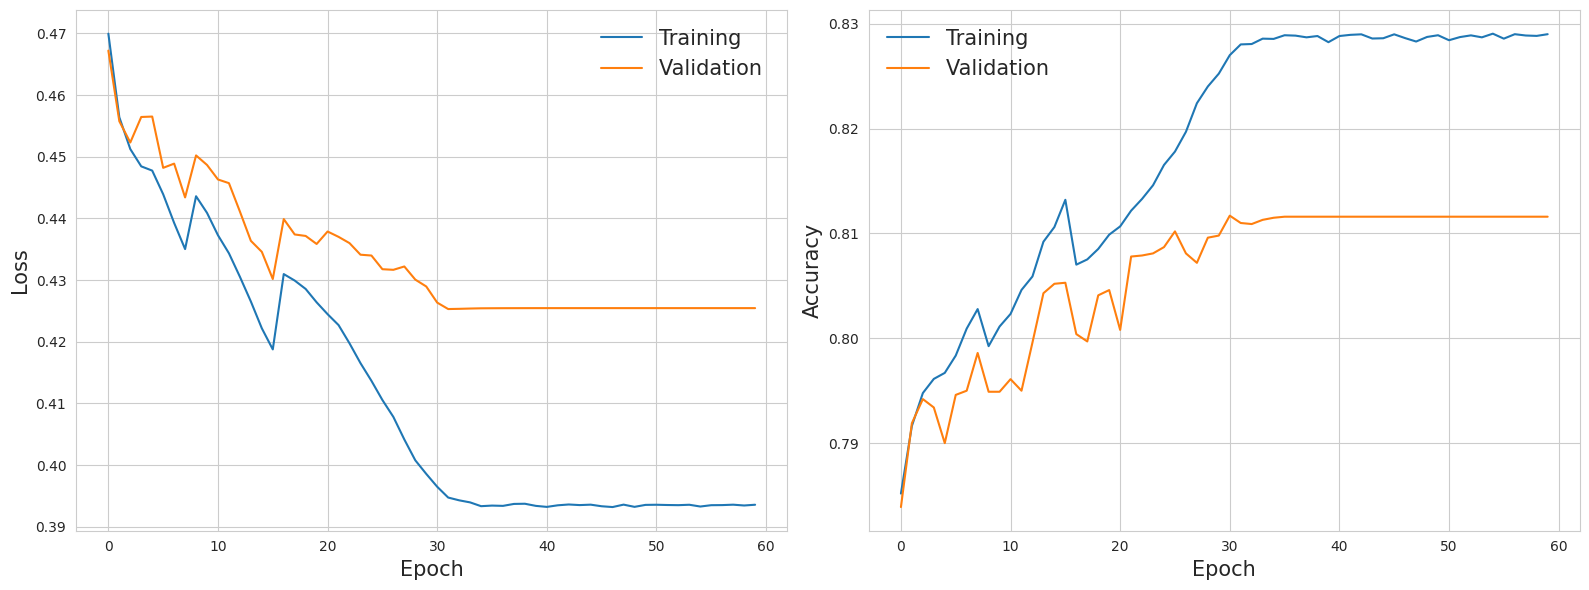

In [142]:
draw_metric_evolution()

In [138]:
res.keys()#['test_auc']

dict_keys(['epochs', 'lr', 'train_time', 'val_time', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'best_val', 'best_epoch', 'test_loss', 'test_acc', 'test_auc', 'test_1/eB_0.3', 'test_1/eB_0.5'])

In [153]:

device = 'cpu'
model.to(device)

LorentzNet(
  (embedding): Linear(in_features=8, out_features=72, bias=True)
  (LGEBs): ModuleList(
    (0-4): 5 x LGEB(
      (phi_e): Sequential(
        (0): Linear(in_features=146, out_features=72, bias=False)
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=72, out_features=72, bias=True)
        (4): ReLU()
      )
      (phi_h): Sequential(
        (0): Linear(in_features=152, out_features=72, bias=True)
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=72, out_features=72, bias=True)
      )
      (phi_x): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): ReLU()
        (2): Linear(in_features=72, out_features=1, bias=False)
      )
      (phi_m): Sequential(
        (0): Linear(in_features=72, out_features=1, bias=True)
        (1): Sigmoid()
      )


In [174]:
pred_val = []
pred_label = []
true_label = []

for i, (label, p4s, nodes, atom_mask, edge_mask, edges) in tqdm(enumerate(dataloaders['test'])):

    batch_size, n_nodes, _ = p4s.size()
    atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
    atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device)
    edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device)
    nodes = nodes.view(batch_size * n_nodes, -1).to(device,dtype)
    edges = [a.to(device) for a in edges]
    label = label.to(device, dtype).long()

    pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

    # print(F.softmax(pred, dim=1).detach())
    pred_val.append(F.softmax(pred, dim=1).cpu().detach().numpy())
    predict = pred.max(1).indices
    pred_label.append(predict)
    true_label.extend([label])#*len(predict))

    correct = torch.sum(predict == label).item()


pred_val = np.concatenate(pred_val, axis=0)
pred_label = np.concatenate(pred_label, axis=0)
true_label = np.concatenate(true_label,axis=0)

79it [01:33,  1.19s/it]


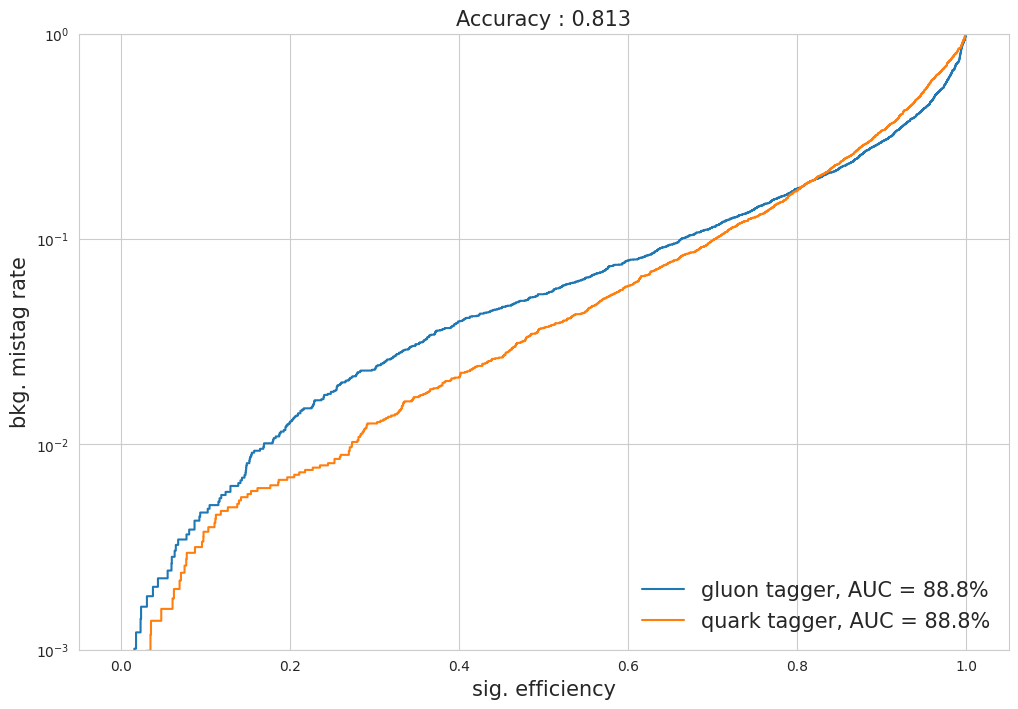

In [175]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#### get the ROC curves
fpr = {}
tpr = {}
auc_value = {}
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    fpr[label], tpr[label], threshold = roc_curve((true_label== i), pred_val[:,i])
    auc_value[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label,auc_value[label]*100.))
#computing accuracy now
acc_score = accuracy_score(true_label, pred_label)
acc_manual = np.sum(pred_label == true_label)
plt.title('Accuracy : {:.3f}'.format(acc_score), fontsize=15)
plt.semilogy()
plt.xlabel("sig. efficiency",fontsize=15)
plt.ylabel("bkg. mistag rate",fontsize=15)
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=15, frameon=False)
plt.show()

### The AUC is ~ 3% higher when we incorporate the corresponding symmetry-preserving bias!

Of course, there is a lot of room to change the architecture, dimension of hidden layers, hyperparameter tuning, etc. But, even without all of this, this showcases how symmetry-preserving behavior is powerful when compared to other standard models, like ParticleNet (which is permutation invariant, so does preserve symmetry to some degree, but not as specific as the LorentzNet).